## Training DynEdge

Now that both database and selection is ready, everything is in place to begin training. DynEdge is a GNN implemented in GraphNeT - it represents IceCube events as 3D point clouds and leverages techniques from segmentation analysis in computer vision to reconstruct events. You can find technical details on the model in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/17/11/P11003). The model and training configuration shown below is nearly identical to what's presented in the paper. Note that this configuration was originally meant for low energy, so it's possible that some adjustments might improve performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
from copy import deepcopy
from graphnet.data.constants import FEATURES, TRUTH
from icecube_utils import make_dataloader

from icecube_utils import (
    load_pretrained_model,
    inference, 
    train_dynedge_from_scratch,
    get_acts_wassersteinized_layers_modularized,
    compute_activations_across_models_v1,
    make_dataloader
)
from graphnet.training.labels import Direction
from parameters import get_parser
from train_large import config

features = FEATURES.KAGGLE
truth = TRUTH.KAGGLE

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


graphnet: INFO     2023-03-04 18:54:38 - get_logger - Writing log to logs/graphnet_20230304-185438.log
graphnet: WARNING  2023-03-04 18:54:39 - warn_once - `icecube` not available. Some functionality may be missing.


In the cell below, you can choose between training dynedge from scratch on the batch_1 database or loading in a pretrained model that has trained on batches 1 to 50.

In [4]:
models = {}

In [5]:
config_small = deepcopy(config)
config_small['dynedge']['dynedge_layer_sizes'] = [(128, 256), (336, 256), (336, 256), (336, 256)]

models['small_seed_0_epochs_10'] = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_0/state_dict.pth')
models['small_seed_1_epochs_10'] = load_pretrained_model(config=config_small, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_small_1/state_dict.pth')

In [6]:
config_large = deepcopy(config)
config_large['dynedge']['dynedge_layer_sizes'] = [(128 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2)]

models['large_seed_0_epochs_10'] = load_pretrained_model(config=config_large, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_large_0_epochs_10/state_dict.pth')

In [7]:
config_large = deepcopy(config)
config_large['dynedge']['dynedge_layer_sizes'] = [(128 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2), (336 * 2, 256 * 2)]

models['large_seed_0_epochs_1'] = load_pretrained_model(config=config_large, state_dict_path='/workspace/icecube/weights/dynedge_pretrained_large_0_epochs_1/state_dict.pth')

In [8]:
# %%capture --no-stdout
# config_large_random = deepcopy(config_large)
# config_large_random['fit']['max_steps'] = 0
# model_large_random = train_dynedge_from_scratch(config=config_large_random)

In [9]:
parser = get_parser()
args = parser.parse_args('--gpu-id 1 --model-name mlpnet --n-epochs 10 --save-result-file sample.csv \
--sweep-name exp_sample --exact --correction --ground-metric euclidean --weight-stats \
--activation-histograms --activation-mode raw --geom-ensemble-type acts --sweep-id 21 \
--act-num-samples 200 --ground-metric-normalize none --activation-seed 21 \
--prelu-acts --recheck-acc --load-models ./mnist_models --ckpt-type final \
--past-correction --not-squared --dist-normalize --print-distances --to-download'.split())

args.gpu_id = 0
args.proper_marginals = True
args.skip_last_layer = True
args.skip_personal_idx = False
args.act_num_samples = 20
args.width_ratio = 1
args.dataset = 'icecube'

In [10]:
train_dataloader = make_dataloader(db = config_small['path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = args.act_num_samples,
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [11]:
layer_names = {
    '_gnn._conv_layers.0.nn.0',
    '_gnn._conv_layers.0.nn.2',
    '_gnn._conv_layers.1.nn.0',
    '_gnn._conv_layers.1.nn.2',
    '_gnn._conv_layers.2.nn.0',
    '_gnn._conv_layers.2.nn.2',
    '_gnn._conv_layers.3.nn.0',
    '_gnn._conv_layers.3.nn.2',
    '_gnn._post_processing.0',
    '_gnn._post_processing.2',
    '_gnn._readout.0',
    '_tasks.0._affine',
}

def map_model(model_from, model_to, dataloader, n_samples):
    models = [
        model_from.cuda(),
        model_to.cuda(), 
    ]
    with torch.no_grad():
        activations = compute_activations_across_models_v1(
            args, 
            models,
            dataloader,
            n_samples,
            mode='raw',
            layer_names=layer_names
        )
        _, mapped_state_dict, _ = get_acts_wassersteinized_layers_modularized(args, models, activations, train_loader=train_dataloader, test_loader=None)
        
    mapped_state_dict = {
        k: v[:, 0] if 'bias' in k else v for k, v in mapped_state_dict.items()
    }

    model_mapped = deepcopy(model_to)
    model_mapped.load_state_dict(mapped_state_dict)

    return model_mapped

In [12]:
models['small_seed_0_epochs_10_mapped'] = map_model(
    models['small_seed_0_epochs_10'], 
    models['small_seed_1_epochs_10'], 
    train_dataloader, 
    args.act_num_samples
)
torch.cuda.empty_cache()

models['large_seed_0_epochs_10_mapped'] = map_model(
    models['small_seed_0_epochs_10'], 
    models['large_seed_0_epochs_10'], 
    train_dataloader, 
    args.act_num_samples
)
torch.cuda.empty_cache()

models['large_seed_0_epochs_1_mapped'] = map_model(
    models['small_seed_0_epochs_10'], 
    models['large_seed_0_epochs_1'], 
    train_dataloader, 
    args.act_num_samples
)
torch.cuda.empty_cache()

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [26346], which does not match the required output shape [4391, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [9588], which does not match the required output shape [1598, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizin

graphnet: INFO     2023-03-04 18:54:45 - KNNGraphBuilder.info - WARNING: GraphBuilder received graph with pre-existing structure. Will overwrite.


/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [8118], which does not match the required output shape [1353, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)


num_personal_idx  0
model_name is  mlpnet
***********
min of act: -1.1325409412384033, max: 1.041191577911377, mean: -0.08256817609071732
activations for idx 0 at layer _gnn._conv_layers.0.nn.0 have the following shape  torch.Size([12844, 128])
-----------
***********
min of act: -0.9590854644775391, max: 0.9545162916183472, mean: -0.03809298202395439
activations for idx 0 at layer _gnn._conv_layers.0.nn.2 have the following shape  torch.Size([12844, 256])
-----------
***********
min of act: -17.302310943603516, max: 24.802783966064453, mean: -0.6187565326690674
activations for idx 0 at layer _gnn._conv_layers.1.nn.0 have the following shape  torch.Size([12784, 336])
-----------
***********
min of act: -23.76776123046875, max: 27.96661949157715, mean: -0.5973536968231201
activations for idx 0 at layer _gnn._conv_layers.1.nn.2 have the following shape  torch.Size([12784, 256])
-----------
***********
min of act: -227.50363159179688, max: 169.9368133544922, mean: -3.1012747287750244
acti

In [13]:
tol = 1e-5
for idx, ((layer0_name, fc_layer0_weight), (layer1_name, fc_layer1_weight)) in \
        enumerate(zip(models['small_seed_0_epochs_10'].named_parameters(), models['small_seed_0_epochs_10_mapped'].named_parameters())):
    with torch.no_grad():
        if not (
            torch.allclose(fc_layer0_weight.mean(), fc_layer1_weight.mean(), rtol=tol, atol=tol) and
            torch.allclose(fc_layer0_weight.abs().mean(), fc_layer1_weight.abs().mean(), rtol=tol, atol=tol) and 
            torch.allclose((fc_layer0_weight.abs() ** 2).mean(), (fc_layer1_weight.abs() ** 2).sum() ** 0.5, rtol=tol, atol=tol)
        ):
            print(layer0_name, fc_layer0_weight.mean(), fc_layer1_weight.mean())

_gnn._conv_layers.0.nn.0.weight tensor(-0.0032, device='cuda:0') tensor(-0.0032, device='cuda:0')
_gnn._conv_layers.0.nn.2.weight tensor(-0.0022, device='cuda:0') tensor(-0.0022, device='cuda:0')
_gnn._conv_layers.1.nn.0.weight tensor(-0.0019, device='cuda:0') tensor(-0.0019, device='cuda:0')
_gnn._conv_layers.1.nn.2.weight tensor(-0.0049, device='cuda:0') tensor(-0.0049, device='cuda:0')
_gnn._conv_layers.2.nn.0.weight tensor(-0.0024, device='cuda:0') tensor(-0.0024, device='cuda:0')
_gnn._conv_layers.2.nn.2.weight tensor(-0.0065, device='cuda:0') tensor(-0.0065, device='cuda:0')
_gnn._conv_layers.3.nn.0.weight tensor(-0.0015, device='cuda:0') tensor(-0.0015, device='cuda:0')
_gnn._conv_layers.3.nn.2.weight tensor(-0.0047, device='cuda:0') tensor(-0.0047, device='cuda:0')
_gnn._post_processing.0.weight tensor(-0.0010, device='cuda:0') tensor(-0.0010, device='cuda:0')
_gnn._post_processing.2.weight tensor(-0.0024, device='cuda:0') tensor(-0.0024, device='cuda:0')
_gnn._readout.0.weight

In [14]:
# with torch.no_grad():
#     model_mapped._gnn._post_processing[0].weight /= 0.5 / 0.7071667
#     model_mapped._gnn._post_processing[2].weight /= 0.5 / 1.0000592
#     model_mapped._gnn._readout[0].weight /= 0.5 / 1.0000384
#     model_mapped._tasks[0]._affine.weight /= 0.7 / 1.0000129

In [15]:
models_names, models_list = [], []
for model_name, model in models.items():
    models_names.append(model_name)
    models_list.append(model)
models_names

['small_seed_0_epochs_10',
 'small_seed_1_epochs_10',
 'large_seed_0_epochs_10',
 'large_seed_0_epochs_1',
 'small_seed_0_epochs_10_mapped',
 'large_seed_0_epochs_10_mapped',
 'large_seed_0_epochs_1_mapped']

set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0
set forward hook for layer named:  _gnn._conv_layers.2.nn.2
set forward hook for layer named:  _gnn._conv_layers.3.nn.0
set forward hook for layer named:  _gnn._conv_layers.3.nn.2
set forward hook for layer named:  _gnn._post_processing.0
set forward hook for layer named:  _gnn._post_processing.2
set forward hook for layer named:  _gnn._readout.0
set forward hook for layer named:  _tasks.0._affine
set forward hook for layer named:  _gnn._conv_layers.0.nn.0
set forward hook for layer named:  _gnn._conv_layers.0.nn.2
set forward hook for layer named:  _gnn._conv_layers.1.nn.0
set forward hook for layer named:  _gnn._conv_layers.1.nn.2
set forward hook for layer named:  _gnn._conv_layers.2.nn.0

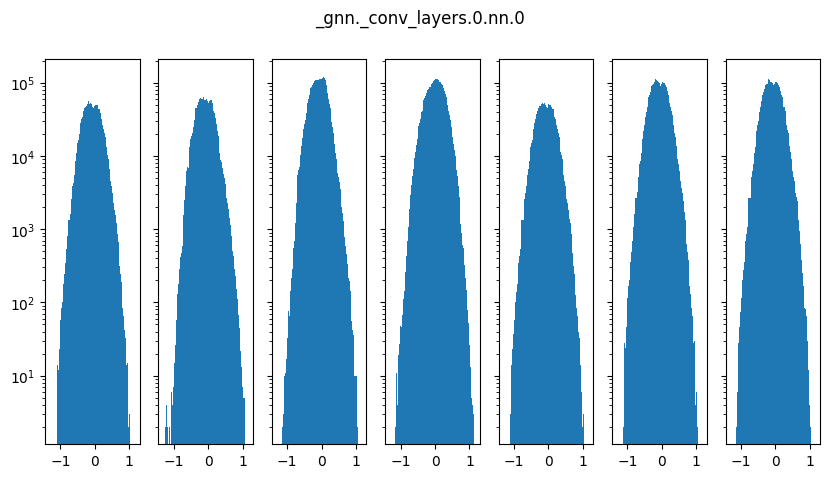

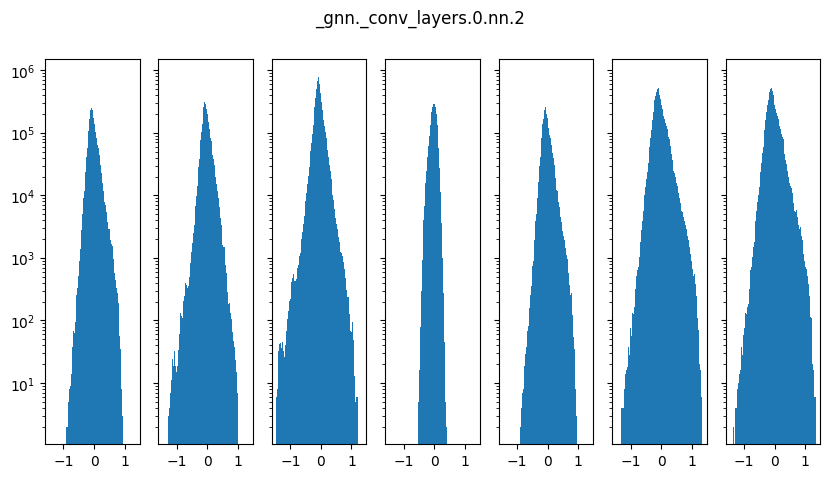

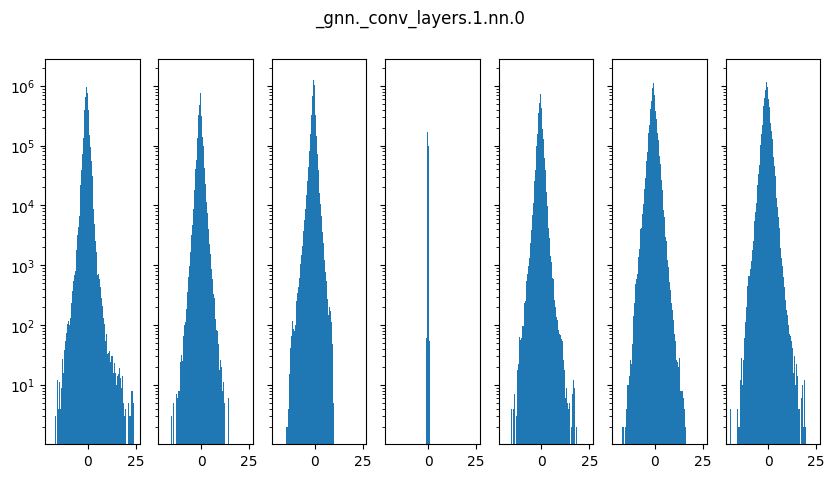

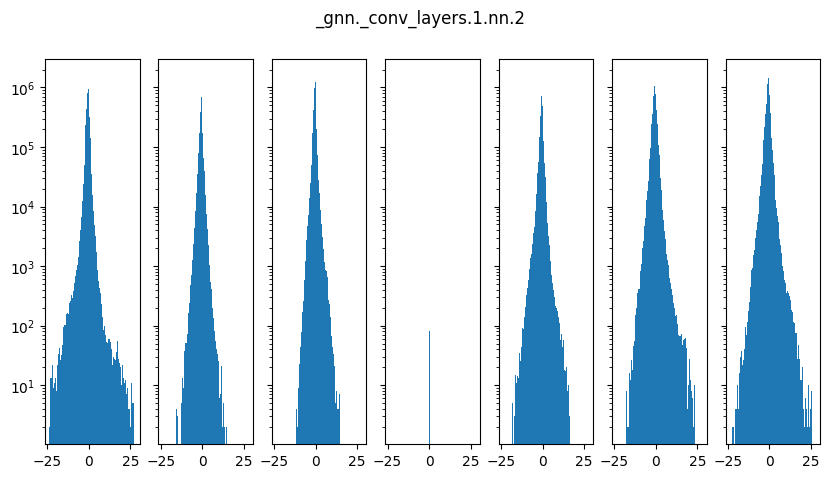

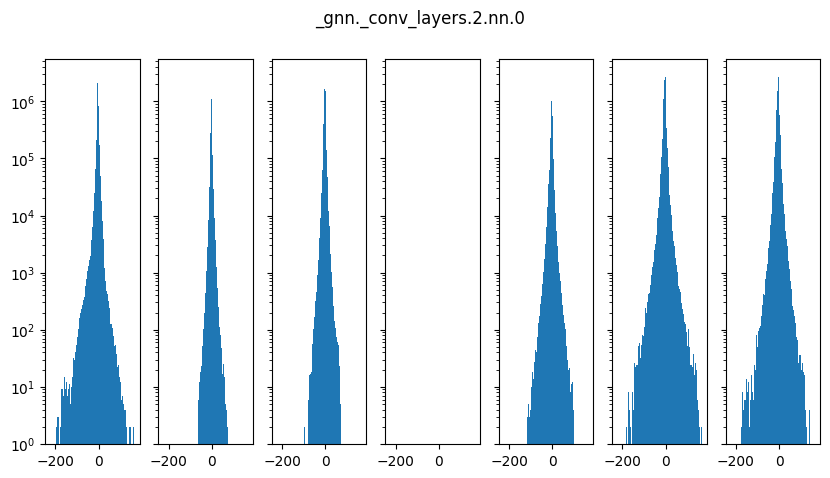

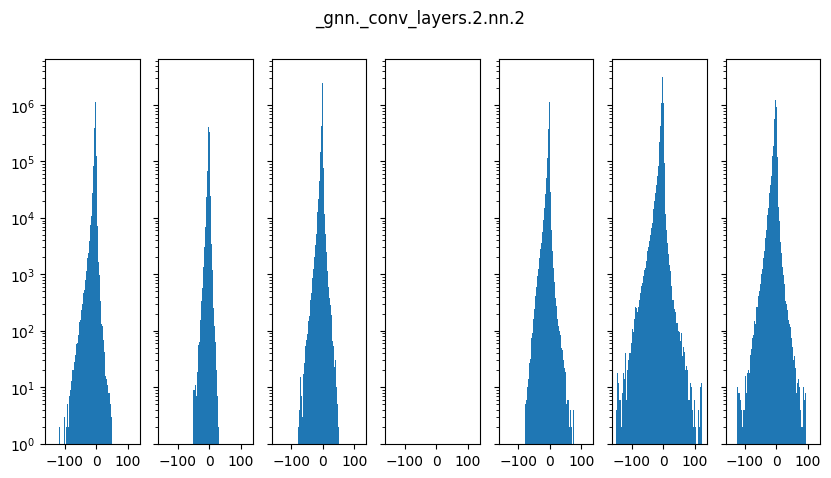

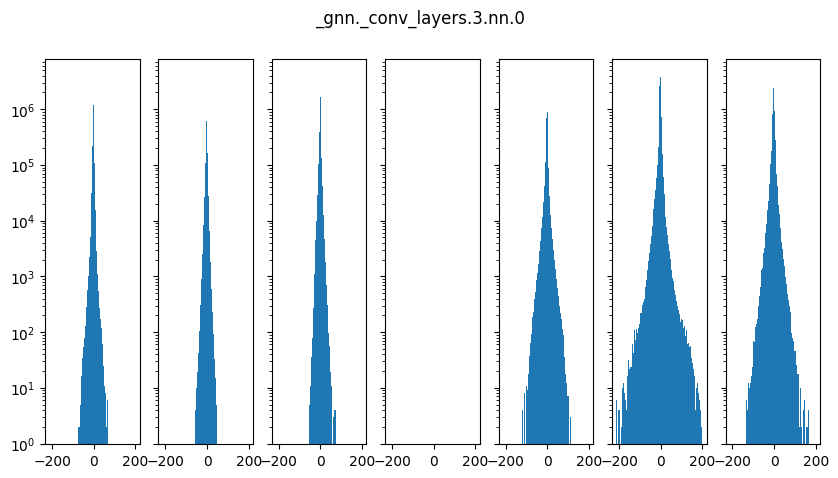

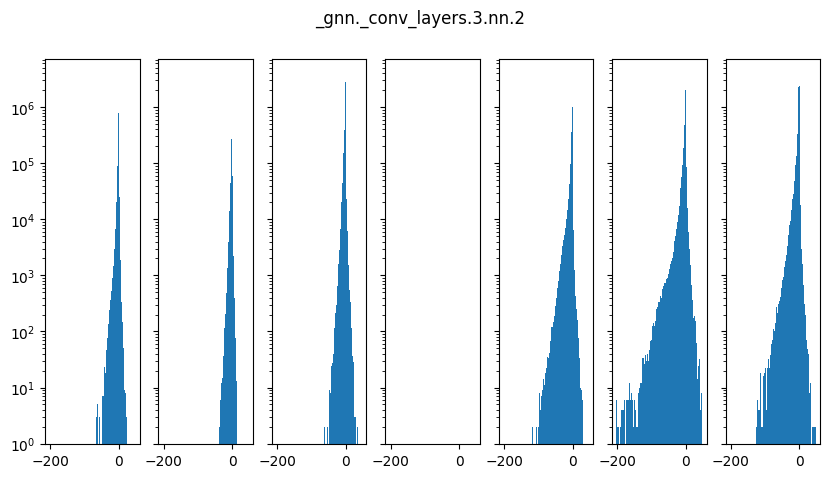

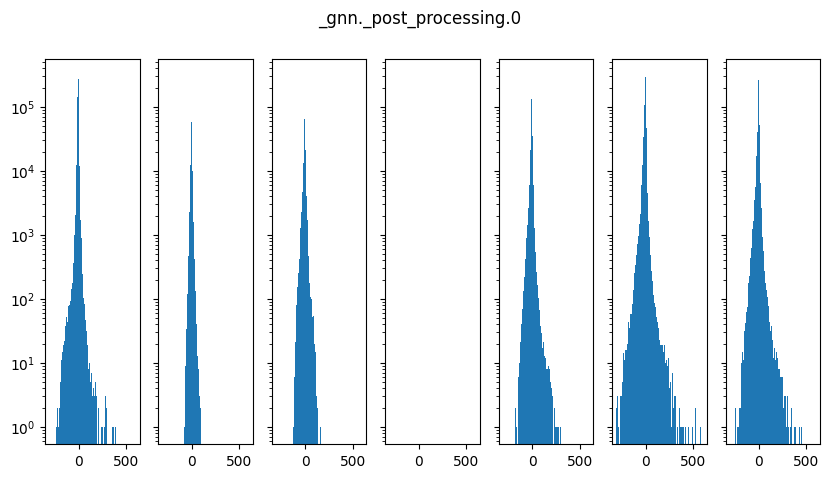

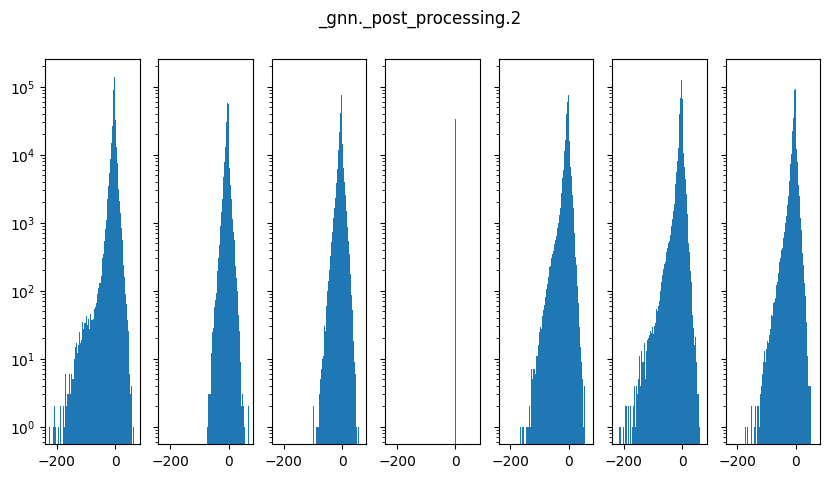

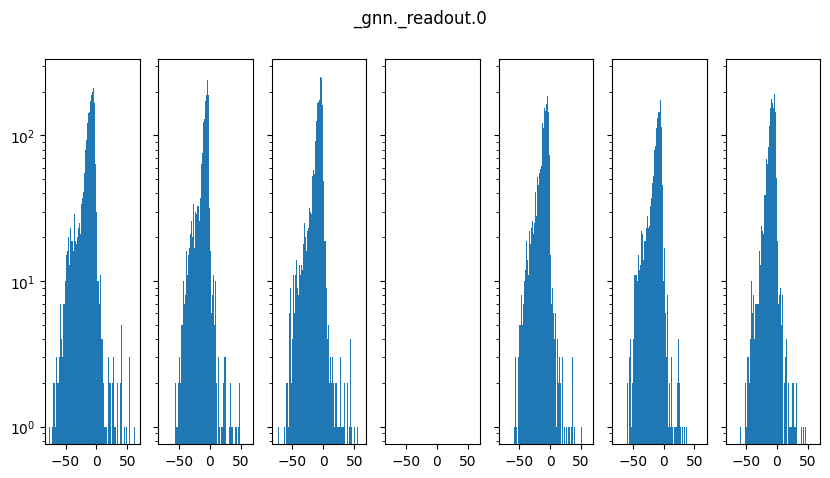

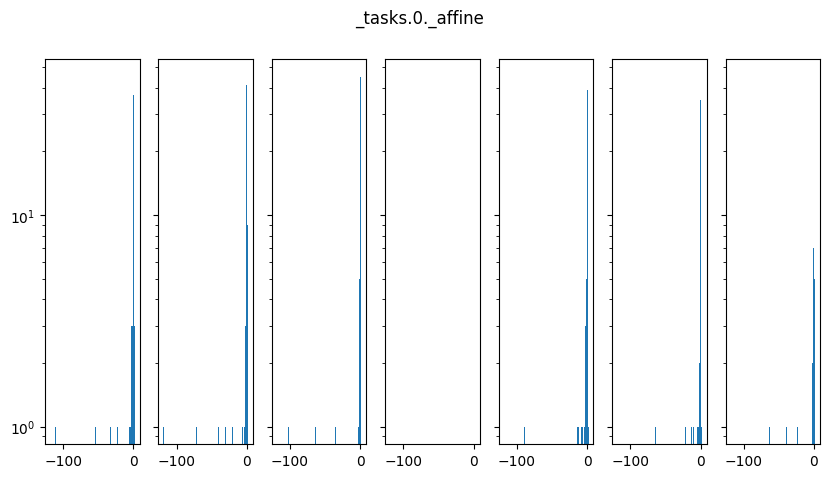

In [16]:
with torch.no_grad():
    activations = compute_activations_across_models_v1(
        args, 
        models_list,
        train_dataloader,
        args.act_num_samples,
        mode='raw',
        layer_names=layer_names
    )

plt.close('all')
for layer_names, acts in zip(
    zip(*[activations[i].keys() for i in range(len(activations))]),
    zip(*[activations[i].values() for i in range(len(activations))])
):
    fig, axes = plt.subplots(1, len(acts), figsize=(10, 5), sharey=True, sharex=True)
    fig.suptitle(layer_names[0])
    print(layer_names[0], [a.shape for a in acts])
    print(layer_names[0], [a.min().item() for a in acts])
    print(layer_names[0], [a.max().item() for a in acts])
    a_std_rel = []
    for i, a in enumerate(acts):
        a_flattened = a.flatten().cpu().numpy()
        if i == 0:
            a_std_rel.append(1)
        else:
            a_std_rel.append(a_flattened.std() / a_std_rel[0])
        axes[i].hist(a_flattened, bins=100)
        axes[i].set_yscale('log')
    print(layer_names[0], a_std_rel)
    print()

In [ ]:
for idx, (
    (layer0_name, fc_layer0_weight), 
    (layer1_name, fc_layer1_weight),
    (layer2_name, fc_layer2_weight),
) in enumerate(zip(
    models['small_seed_0_epochs_10'].named_parameters(), 
    models['small_seed_0_epochs_10_mapped'].named_parameters(),
    models['large_seed_0_epochs_10_mapped'].named_parameters(),
)):
    with torch.no_grad():
        s1 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer1_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        s2 = (((fc_layer0_weight.abs() ** 2).sum() ** 0.5) / ((fc_layer2_weight.abs() ** 2).sum() ** 0.5)).cpu().numpy()
        print(layer0_name, s1, s2)

_gnn._conv_layers.0.nn.0.weight 1.0000128 0.707125
_gnn._conv_layers.0.nn.2.weight 1.0000384 0.5000384
_gnn._conv_layers.1.nn.0.weight 1.0000591 0.5000592
_gnn._conv_layers.1.nn.2.weight 1.0000592 0.5000592
_gnn._conv_layers.2.nn.0.weight 1.0000592 0.5000592
_gnn._conv_layers.2.nn.2.weight 1.0000592 0.5000592
_gnn._conv_layers.3.nn.0.weight 1.0000592 0.5000591
_gnn._conv_layers.3.nn.2.weight 1.0000592 0.5000592
_gnn._post_processing.0.weight 1.0000587 0.71088207
_gnn._post_processing.2.weight 1.0000592 1.0000591
_gnn._readout.0.weight 1.0000385 1.0000385
_tasks.0._affine.weight 1.0000128 1.0000128


In [ ]:
test_dataloader = make_dataloader(db = config_small['inference_database_path'],
    selection = None, # Entire database
    pulsemaps = config_small['pulsemap'],
    features = features,
    truth = truth,
    batch_size = config_small['batch_size'],
    num_workers = config_small['num_workers'],
    shuffle = False,
    labels = {'direction': Direction()},
    index_column = config_small['index_column'],
    truth_table = config_small['truth_table'],
)

In [ ]:
# from torchviz import make_dot

# x = next(iter(test_dataloader)).cpu()
# y = model_small_seed_0.cpu()(x)

# make_dot(sum(y) / len(y), params=dict(list(model_small_seed_0.named_parameters()))).render("rnn_torchviz", format="png")

/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [300], which does not match the required output shape [100, 3]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:17.)
  value = torch.cat(values, dim=cat_dim or 0, out=out)
/root/miniconda3/envs/graphnet/lib/python3.8/site-packages/torch_geometric/data/collate.py:150: UserWarning: An output with one or more elements was resized since it had shape [55314], which does not match the required output shape [9219, 6]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing 

In [ ]:
resilts = defaultdict(list)
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        for model_name, model in models.items():
            resilts[model_name].append(model(batch.cuda()))
    if i > 100:
        break
print(*[model_name for model_name in resilts.keys()])
for x in zip(*[resilts[model_name] for model_name in resilts.keys()]):
    print([(np.abs(y[0].cpu().numpy()) ** 2).sum() ** 0.5 for y in x])

In [ ]:
vs = []
for a, b, c in zip(models['small_seed_0_epochs_10'], models['small_seed_1_epochs_10'], models['small_seed_0_epochs_10_mapped']):
    print(
        v := ((np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5) / ((
            ((np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5) +
            ((np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5)
        ) / 2)
    )
    vs.append(v)

0.7094946027372634
1.1294778917797688
0.8170302896232713
1.12797236552434
0.7495856745052625
0.7680559813707611
1.0511098717558993
0.6142274092344437
0.6901523543019394
0.7931526355240274
0.6918536896154366
0.7539773682243746
0.8917250173915617
0.7814085363187775
0.8163306509430815
0.49320500495946484
0.790682938110545
1.0245463460473905
0.6544302619247042
0.9033840775046984
0.5774004538778444
0.49570851081282497
0.7543168595705708
0.7127959776126829
0.7460334410998734
0.7143117244168601
1.072057930196843
1.1110300535306703
0.7843814006587404
0.8110464786773445
0.7830589915889938
0.8037546905918469
0.8796158952334239
0.5668433721979299
0.7571791154009802
0.9234565526013073
0.9206133573149855
0.9524628474198289
0.6287037652309543
0.7777570483383095
0.8898851576672945
0.7964136907483438
0.6947727618333756
0.8934560018888705
0.6485834699210223
0.532572838177545
0.7390420598239109
0.7383250415599085
0.9222881751542106
1.0009759772078701
0.637504806442919
0.9284484445734775
0.84775509361575

In [ ]:
sum(vs) / len(vs)

0.7726542878796787

In [ ]:
vs = []
for a, b, c in zip(models['small_seed_0_epochs_10'], models['small_seed_1_epochs_10'], models['large_seed_0_epochs_10_mapped']):
    print(
        v := ((np.abs(c[0].cpu().numpy()) ** 2).sum() ** 0.5) / ((
            ((np.abs(a[0].cpu().numpy()) ** 2).sum() ** 0.5) +
            ((np.abs(b[0].cpu().numpy()) ** 2).sum() ** 0.5)
        ) / 2)
    )
    vs.append(v)

0.8139601526785336
0.7811485925268133
0.5573255596332153
0.6003016438284001
0.5647555790728713
0.6556305506020975
0.566081191422976
0.6371792033409033
0.5762329915271931
0.6856117295584854
0.5730182858493165
0.5241341497908795
0.6810715710231423
0.5601318917666865
0.6364420146482986
0.6467236900110532
0.7712998218651923
0.6372925192606478
0.7427105279537056
0.5359980740615898
0.5888354218334927
0.580618688323033
0.6152277034249123
0.6551127124029308
0.5613817817090974
0.7638182991207666
0.6244175132527785
0.9306731011113104
0.7468965247649422
0.573959616932656
0.610123576967487
0.8387593683683431
0.9107745997693707
0.6190183645922452
0.6229527495603868
0.5866161944609583
0.6052439302995714
0.5518233489538567
0.6073179506320581
0.7738039433825015
0.6924440787045067
0.6045846268209495
0.8281845215296953
0.631697383909923
0.6518757348188167
0.5302854433633674
0.6337385926095921
0.6416660540884437
0.6056187701344267
0.4887550337997603
0.6690685668125779
0.8799474495716741
0.666347041446012

In [ ]:
sum(vs) / len(vs)

0.6577432671287089

## Inference & Evaluation

With a trained model loaded into memory, we can now apply the model to batch_51. The following cells will start inference (or load in a csv with predictions, if you're in a hurry) and plot the results. 

In [ ]:
def convert_to_3d(df: pd.DataFrame) -> pd.DataFrame:
    """Converts zenith and azimuth to 3D direction vectors"""
    df['true_x'] = np.cos(df['azimuth']) * np.sin(df['zenith'])
    df['true_y'] = np.sin(df['azimuth']) * np.sin(df['zenith'])
    df['true_z'] = np.cos(df['zenith'])
    return df

def calculate_angular_error(df : pd.DataFrame) -> pd.DataFrame:
    """Calcualtes the opening angle (angular error) between true and reconstructed direction vectors"""
    df['angular_error'] = np.arccos(df['true_x']*df['direction_x'] + df['true_y']*df['direction_y'] + df['true_z']*df['direction_z'])
    return df

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_seed_0, config_small))) 
# df.to_hdf('results/small_0.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:14<00:00, 14.82it/s]
graphnet: INFO     2023-03-04 16:59:43 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_seed_1, config_small))) 
# df.to_hdf('results/small_1.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:14<00:00, 14.82it/s]
graphnet: INFO     2023-03-04 17:02:31 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large, config_large)))
# df.to_hdf('results/large.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:48<00:00,  8.75it/s]
graphnet: INFO     2023-03-04 18:18:56 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_random, config_large_random)))
# df.to_hdf('results/large_random.h5', key='df', mode='w')

In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_large_mapped, config_large)))
# df.to_hdf('results/large_mapped.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s]
graphnet: INFO     2023-03-04 18:23:27 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
# %%capture --no-stdout
# df = calculate_angular_error(convert_to_3d(inference(model_small_mapped, config_small)))
# df.to_hdf('results/small_mapped.h5', key='df', mode='w')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2000/2000 [02:15<00:00, 14.79it/s]
graphnet: INFO     2023-03-04 17:05:19 - inference - Writing results to training/train_model_without_configs/batch_1/dynedge_direction_my_example


In [ ]:
%%capture --no-stdout
df = calculate_angular_error(convert_to_3d(inference(models['large_seed_0_epochs_1_mapped'], config_large)))
df.to_hdf('results/large_seed_0_epochs_1_mapped.h5', key='df', mode='w')

In [ ]:
results = {
    'small_0': pd.read_hdf('results/small_0.h5', key='df'),
    'small_1': pd.read_hdf('results/small_1.h5', key='df'),
    'large': pd.read_hdf('results/large.h5', key='df'),
    'small_mapped': pd.read_hdf('results/small_mapped.h5', key='df'),
    'large_mapped': pd.read_hdf('results/large_mapped.h5', key='df'),
    'large_seed_0_epochs_1_mapped': pd.read_hdf('results/large_seed_0_epochs_1_mapped.h5', key='df'),
}

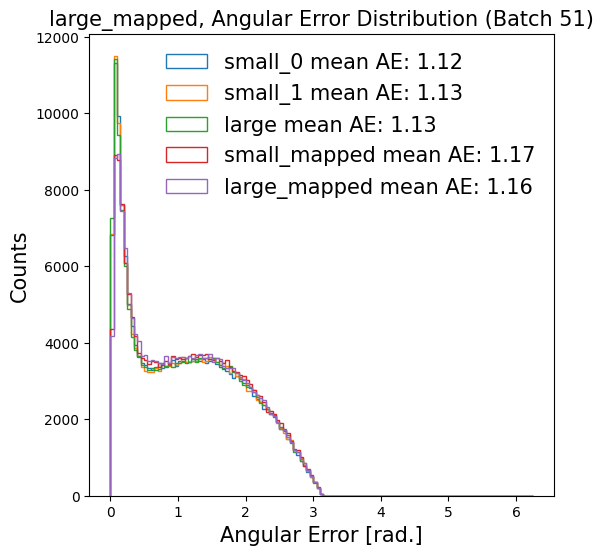

In [ ]:
fig = plt.figure(figsize = (6,6))
for name, result in results.items():
    plt.hist(result['angular_error'], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'{name} mean AE: {np.round(result["angular_error"].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
plt.legend(frameon = False, fontsize = 15)

So the pre-trained dynedge seems to perform quite well. Another interesting feature of the reconstruction is that dynedge (when coupled with the[ DirectionReconstructionWithKappa](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/models/task/reconstruction.py#L45) is that dynedge estimated *kappa* the concentration parameter from the vonMisesFisher distribution. Kappa is analogus to sigma via sigma = 1/sqrt(kappa), and the quality of the direction estimate should be highly correlated with this parameter. 

In [ ]:
cut_threshold = 0.5
for name, result in results.items():
    fig = plt.figure(figsize = (6,6))
    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) <= cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma <= {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) <= cut_threshold].mean(),2)}')

    plt.hist(result['angular_error'][1/np.sqrt(result['direction_kappa']) > cut_threshold], 
            bins = np.arange(0,np.pi*2, 0.05), 
            histtype = 'step', 
            label = f'sigma > {cut_threshold}: {np.round(result["angular_error"][1/np.sqrt(result["direction_kappa"]) > cut_threshold].mean(),2)}')
    plt.xlabel('Angular Error [rad.]', size = 15)
    plt.ylabel('Counts', size = 15)
    plt.title(f'{name}, Angular Error Distribution (Batch 51)', size = 15)
    plt.legend(frameon = False, fontsize = 15)

As you can see, the variable can be used to distinguish "good" and "bad" reconstructions with some confidence. 

## A few hints for your neutrino data science journey!

* The configuration of dynedge shown in this notebook is the so-called "baseline". It's not optimized for high energy neutrinos, so you might be able to squeeze out a bit more performance by tuning hyperparameters or making larger modifications; such as switching out the learning rate scheduler or choosing a different loss function, etc.

* You can use the kappa variable to group events into different categories. Perhaps training a seperate reconstruction method for each performs better?

* You may want to adjust the [ParquetDataset](https://github.com/graphnet-team/graphnet/blob/7e857562898ebebebc9a105159fd3d4eb4994aea/src/graphnet/data/parquet/parquet_dataset.py#L11) such that it works with the competition data. This would allow you to train / infer directly on the competition files (No conversion to sqlite needed). Feel free to contribute this to the repository!


Good luck!